In [1]:
import psycopg2
from psycopg2.extensions import register_adapter, AsIs
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import collections
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.cluster import KMeans
import string
import wfdb

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
np.set_printoptions(suppress=True,precision=10)

In [2]:
def obtainMeasures(dbname="mimic",unlimit=False,centroid=None) :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    limit = "" if unlimit else " ORDER BY random() LIMIT 20000 "
    null = " AND centroid is null" if centroid is None else "AND centroid IS NOT NULL" if centroid =="notNull" else "" 
    paramCentroid = ",centroid " if centroid == "notNull" else ""
    select_stament = ("SELECT qt,ts,sr"+paramCentroid+" FROM rstq "
                      " WHERE qt > 0 AND qt<1000 "
                      " AND ts > 0 "
                      " AND sr IS NOT NULL GROUP BY qt,ts,sr"+paramCentroid+null+limit)
    print(select_stament)
    cur.execute(select_stament)
    waves = []
    for row in cur :
        qt = row[0]
        ts = row[1]
        sr = row[2]
        if centroid  =="notNull" :
            waves.append([qt,ts,sr,row[3]])
        else :
            waves.append([qt,ts,sr])
    conn.close()
    print("number of distinct heartbeats:",len(waves))
    return waves

In [3]:
def printKmeans(kmeans) :
    labels, values = zip(*collections.Counter(kmeans.labels_).items())
    indexes = np.arange(len(labels))
    width = 0.5
    fig, ax = plt.subplots() 
    for i, v in enumerate(values):
        ax.text(i-0.1,v+1, str(v), color='blue', fontweight='bold')
    plt.bar(indexes, values, width)
    plt.title('Cantidad de Latidos por centroide')
    plt.ylabel('Cantidad de latidos')
    plt.xlabel('Centroides')
    numberToAlpha = dict(enumerate(string.ascii_lowercase, 0))    
    plt.xticks(indexes + width * 0.01, [numberToAlpha[label] for label in labels])
    plt.show()

In [4]:
def findElbow(X):
    # k means determine k
    distortions = []
    K = range(2,22,2)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(X)
        cluster_labels = kmeanModel.fit_predict(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
        print("K=",k,end=",")
    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.xticks(K)
    plt.show()
    for i in range(1,len(distortions)) :
        print(str(i*2)+":",distortions[i-1]-distortions[i],end=", ")

In [5]:
def printSilhouette(X):
    range_n_clusters = range(2,22,2)
    for n_clusters in range_n_clusters:
        fig = plt.figure()
        ax1 = fig.add_subplot(121)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,facecolor=color, 
                              edgecolor=color, alpha=0.7)
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10  # 10 for the 0 samples
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        ax2 = fig.add_subplot(122, projection='3d')
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        qt = np.array([-item[0] for item in X])
        ts = np.array([item[1] for item in X])
        sr = np.array([item[2] for item in X])
        ax2.scatter(ts,qt, sr, marker='.', lw=0, alpha=0.7,c=colors, edgecolor='k')
        centers = clusterer.cluster_centers_
        ax2.scatter(centers[:, 0], centers[:, 1],centers[:, 2], marker='o',c="white", alpha=1, s=200, edgecolor='k')
        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1],c[2], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")
        ax2.set_zlabel("Feature space for the 3nd feature")
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
        plt.show()

In [6]:
waves = obtainMeasures(centroid="all",unlimit=False)
X = np.array(waves)

SELECT qt,ts,sr FROM rstq  WHERE qt > 0 AND qt<1000  AND ts > 0  AND sr IS NOT NULL GROUP BY qt,ts,sr ORDER BY random() LIMIT 20000 
number of distinct heartbeats: 20000


### Let's find an possible Elbow in the k-means to choise the value of k

For n_clusters = 2 The average silhouette_score is : 0.654460516966


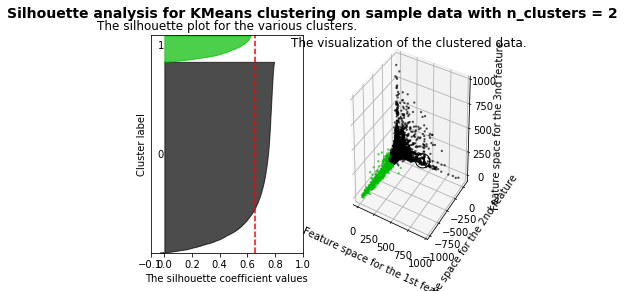

For n_clusters = 4 The average silhouette_score is : 0.534526746903


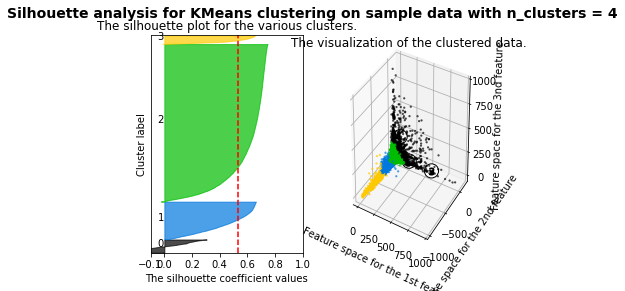

For n_clusters = 6 The average silhouette_score is : 0.433142149414


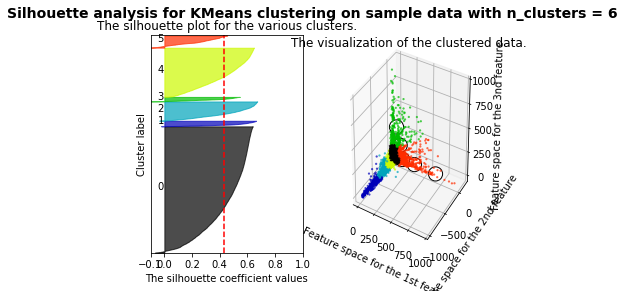

For n_clusters = 8 The average silhouette_score is : 0.380507770863


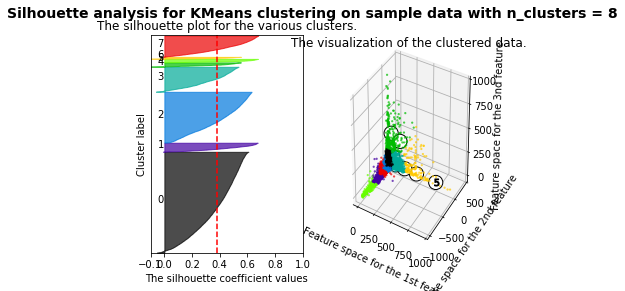

For n_clusters = 10 The average silhouette_score is : 0.351927080968


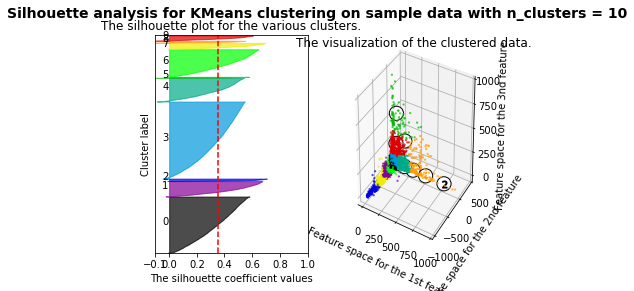

For n_clusters = 12 The average silhouette_score is : 0.335394356954


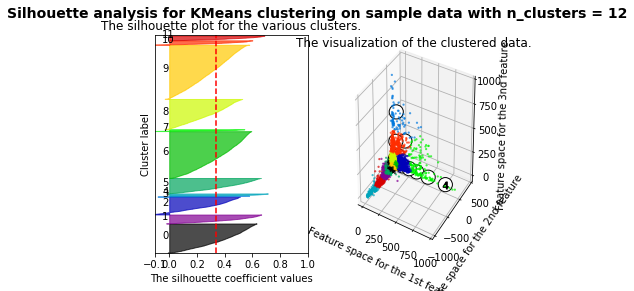

For n_clusters = 14 The average silhouette_score is : 0.323964837818


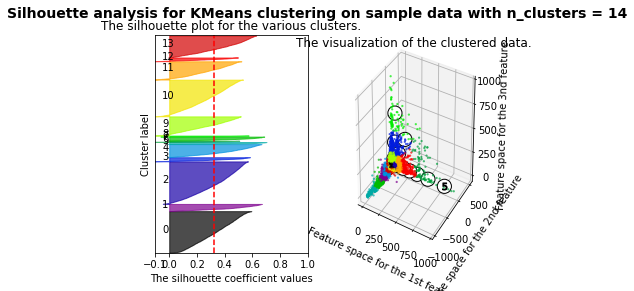

For n_clusters = 16 The average silhouette_score is : 0.341958554138


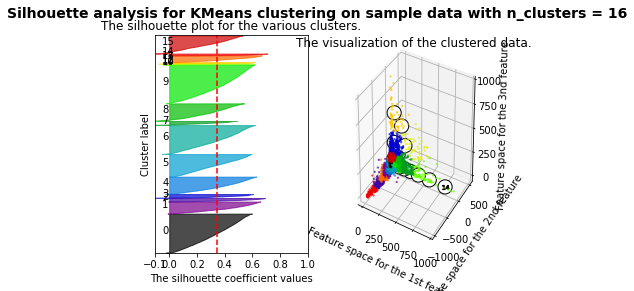

For n_clusters = 18 The average silhouette_score is : 0.32304472713


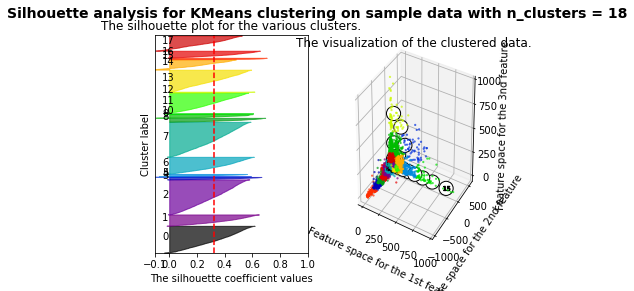

For n_clusters = 20 The average silhouette_score is : 0.318317441461


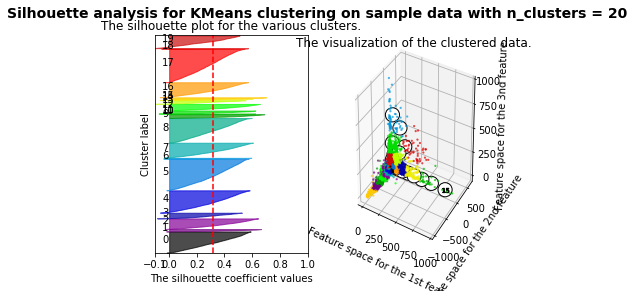

In [7]:
printSilhouette(X)

In [ ]:
waves = obtainMeasures(centroid="all",unlimit=True)
X = np.array(waves)

SELECT qt,ts,sr FROM rstq  WHERE qt > 0 AND qt<1000  AND ts > 0  AND sr IS NOT NULL GROUP BY qt,ts,sr
number of distinct heartbeats: 481346


In [ ]:
findElbow(X)

K= 2,K= 4,K= 6,K= 8,K= 10,K= 12,K= 14,K= 16,

### Not clear elbow found, but how im interested more to find a value where the distortion is low, all over 6 gives a distorsion lower that 1%, so lets stay with that

In [ ]:
centroid=np.array([
 [80.6249206776,34.4072341942,18.0654919722]
,[27.5433134377,63.0542687151,20.1936270556]
,[37.8806590078,28.0581910623,58.6082070374]
,[153.5995271557,33.0196033362,14.637847245]
,[32.7841950261,141.3795344053,49.8454796185]
,[252.6050595323,32.6354966736,14.6705593467]
,[372.7386300819,30.7641087492,15.2788079803]
,[542.3333662583,29.6270248913,14.8596404583]
,[31.1998859099,77.3158014832,247.2476896749]
,[789.1761990768,28.8695564921,13.7471402769]
,[25.309598268,439.5821505894,107.6622564349]
,[28.524825784,99.4141986063,577.2391114982]])
kmeans = KMeans(n_clusters=12
                ,init=centroid,n_init=1
               ).fit(X)

In [ ]:
centroid = kmeans.cluster_centers_
print(centroid)

In [ ]:
printKmeans(kmeans)